# The Simpsons Social Network Analysis
## Project B - 02805 Social Graphs and Interactions

**Group 25:**
- **Yashasvi Tirpur Vishwanath** (s242563)
- **Chinmay Prasad Dongarkar** (s250155)
- **Vaibhav Anil Nagwani** (s242572)

**Research Question**: How does Springfield's social network of secondary characters evolve across The Simpsons' run, and which non-protagonist characters emerge as structural hubs and bridges when the most central secondary character is controlled for?

### Hypotheses
1. **H1 (Temporal Evolution)**: The network becomes denser and more interconnected over time
2. **H2 (Centrality Shifts)**: Secondary characters (Moe, Burns, Skinner, Apu, Krusty) exhibit increasing relative importance in later seasons
3. **H3 (Central Character as Structural Glue)**: Removing the most central secondary character fragments the network and reveals alternative structural hubs among non-protagonists
4. **H4 (Community-Centrality Alignment)**: Bridge characters have higher betweenness but not necessarily higher degree
5. **H5 (Text-Network Correspondence)**: Characters in the same structural community share semantic themes

### Research Focus
Our analysis focuses exclusively on secondary characters (104 characters with ≥2 episode appearances). Main Simpson family members are not included in this dataset. To identify structural hubs among non-protagonists, we examine how network structure changes when the most central secondary character is removed, revealing which other characters emerge as important structural nodes.

---

## 1. Setup and Imports

In [1]:
# Standard library imports
import os
import re
import json
from pathlib import Path
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Network analysis
import networkx as nx
from networkx.algorithms import community

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Random seed for reproducibility
np.random.seed(42)

print("All imports successful!")

All imports successful!


In [2]:
# Download NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')

print("NLTK resources ready!")

NLTK resources ready!


## 2. Data Loading and Preprocessing

We have Simpsons Wiki character pages (499 .txt files with character info and episode appearances).

In [3]:
# Define paths
DATA_DIR = Path.cwd()
WIKI_DIR = DATA_DIR / "wiki_pages_simpsons_copy"

# Verify paths exist
assert WIKI_DIR.exists(), f"Wiki directory not found: {WIKI_DIR}"

# Count files
wiki_files = list(WIKI_DIR.glob("*.txt"))
print(f"Found {len(wiki_files)} character wiki pages")

Found 499 character wiki pages


### 2.1 Parse Character Wiki Pages

In [4]:
def parse_wiki_page(file_path):
    """
    Parse a Simpsons Wiki character page and extract:
    - Character name, metadata (sex, job, status, etc.)
    - Full text content, episode appearances, categories
    """
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    
    char_name = file_path.stem
    metadata = {}
    
    # Extract name from template
    name_match = re.search(r'\|name\s*=\s*([^\n\|]+)', content)
    metadata['name'] = name_match.group(1).strip() if name_match else char_name
    
    # Extract sex
    sex_match = re.search(r'\|sex\s*=\s*\{\{(Male|Female)\}\}', content, re.IGNORECASE)
    metadata['sex'] = sex_match.group(1) if sex_match else 'Unknown'
    
    # Extract job
    job_match = re.search(r'\|job\s*=\s*([^\n\|]+)', content)
    metadata['job'] = job_match.group(1).strip() if job_match else None
    
    # Extract status
    status_match = re.search(r'\|status\s*=\s*\{\{(Alive|Deceased|Fictional)\}\}', content, re.IGNORECASE)
    metadata['status'] = status_match.group(1) if status_match else 'Unknown'
    
    # Extract episode appearances: {{Ep|Episode Name}}
    episodes = re.findall(r'\{\{Ep\|([^}]+)\}\}', content)
    episodes = [ep.strip() for ep in episodes]
    
    # Extract categories
    categories = re.findall(r'\[\[Category:([^\]]+)\]\]', content)
    categories = [cat.strip() for cat in categories]
    
    # Extract main text (remove wiki markup)
    text = re.sub(r'\{\{[^}]+\}\}', '', content)
    text = re.sub(r'\[\[Category:[^\]]+\]\]', '', text)
    text = re.sub(r'\[\[File:[^\]]+\]\]', '', text)
    text = re.sub(r'\[\[([^\|\]]+)\|([^\]]+)\]\]', r'\2', text)
    text = re.sub(r'\[\[([^\]]+)\]\]', r'\1', text)
    text = re.sub(r'=+[^=]+=+', '', text)
    text = ' '.join(text.split())
    
    return {
        'character': char_name,
        'name_display': metadata['name'],
        'sex': metadata['sex'],
        'job': metadata['job'],
        'status': metadata['status'],
        'episodes': episodes,
        'num_episodes': len(episodes),
        'categories': categories,
        'text': text,
        'text_length': len(text)
    }

# Test parsing
test_file = WIKI_DIR / "50 Cent (character).txt"
if test_file.exists():
    test_result = parse_wiki_page(test_file)
    print(f"Character: {test_result['character']}")
    print(f"Episodes: {test_result['episodes']}")
    print(f"Categories: {test_result['categories'][:5]}")

Character: 50 Cent (character)
Episodes: ['Pranksta Rap']
Categories: ['Male characters', 'Adults', 'Celebrities', 'Musicians', 'Real world characters']


In [5]:
# Parse all character files
print("Parsing all character wiki pages...")
characters_data = []

for file_path in wiki_files:
    try:
        char_data = parse_wiki_page(file_path)
        characters_data.append(char_data)
    except Exception as e:
        print(f"Error parsing {file_path.name}: {e}")

df_characters = pd.DataFrame(characters_data)
print(f"\nParsed {len(df_characters)} characters")
df_characters.head()

Parsing all character wiki pages...

Parsed 499 characters


,character,name_display,sex,job,status,episodes,num_episodes,categories,text,text_length
0,Angelica D'Amico,Angelica D'Amico,Female,None,Alive,"[The Real Housewives of Fat Tony, Whistler's F...",4,"[D'Amico family, Female characters, Widows, Se...",|status '''Husband''': Fatso Antonio (deceased...,1200
1,Bigger Brothers clerk,Bigger Brothers Clerk,Female,Clerk,Unknown,[Brother from the Same Planet],1,"[Blonde Characters, Adults, Minor Characters, ...",|hair |job |appearanceTress MacNeille }} The '...,345
2,Amenhotep,Amenhotep,Male,None,Fictional,[],0,"[Monsters, Treehouse of Horror characters, Tap...",|status Womenhet (Wife) |appearance Hank Azari...,432
3,Antarctic Researcher 2,Antarctic Researcher 2,Male,Researcher,Alive,[Bart vs. Australia],1,"[Characters, Nameless characters, One-time cha...",|status Dark yellow |job Bart vs. Australia |v...,84
4,Ankylosaurus,Ankylosaurus,Unknown,None,Unknown,[],0,"[Dinosaurs, Treehouse of Horror characters, An...",Ankylosaurus's are dinosaurs. <gallery> Ankylo...,72


In [6]:
# Basic statistics
print("="*60)
print("CHARACTER DATA SUMMARY")
print("="*60)
print(f"Total characters: {len(df_characters)}")
print(f"Characters with episodes: {(df_characters['num_episodes'] > 0).sum()}")
print(f"\nTop 20 characters by episode count:")
print(df_characters.nlargest(20, 'num_episodes')[['character', 'num_episodes', 'sex', 'job']])

CHARACTER DATA SUMMARY
Total characters: 499
Characters with episodes: 323

Top 20 characters by episode count:
                        character  num_episodes      sex  \
335              Jasper Beardsley            92     Male   
133                  Chuck Berger            83     Male   
457              Kumiko Albertson            61  Unknown   
443                  Adrian Belew            57     Male   
293                 Becky Shorter            51   Female   
181   Audrey McConnell's Students            42  Unknown   
129  Audrey McConnell's Student 8            37   Female   
258  Audrey McConnell's Student 1            32     Male   
357  Audrey McConnell's Student 4            27     Male   
412             Barry Mackleberry            25     Male   
289  Audrey McConnell's Student 2            24     Male   
256                      Benjamin            19     Male   
12                  Violet Bazaar            17   Female   
145               Abraham Lincoln            17 

### 2.2 Extract Unique Episodes

In [7]:
# Extract all unique episodes
all_episodes = set()
for episodes in df_characters['episodes']:
    all_episodes.update(episodes)

print(f"Total unique episodes: {len(all_episodes)}")
print(f"\nSample episodes: {list(all_episodes)[:20]}")

Total unique episodes: 843

Sample episodes: ['To Surveil With Love|(Seen with his father at the second debate)', 'Marge vs. Singles, Seniors, Childless Couples and Teens and Gays|(Seen hugging one of the adults)', "Bull-E|(Springfield Founder's Day Parade)", "Lisa Simpson, This Isn't Your Life|(Seen at the playground)", 'Tales from the Public Domain', 'Homer the Heretic', '24 Minutes|(Gymnasium)', 'Any Given Sundance', "Lisa's Substitute|(first appearance)", "There's Something About Marrying", 'Who Shot Mr. Burns? (Part One)', 'Smart and Smarter|(referenced and photo seen)', 'Bart vs. Thanksgiving', 'Looking for Mr. Goodbart|Helping Homer, Bart and Lisa find Phoebe', '3 Scenes Plus a Tag from a Marriage|(background)', 'D\'oh Canada|(Homer\'s outro after singing "[[Upstate New York]]")', 'Halloween of Horror|(Pine Hills block party)', 'The Kid is All Right|(non-speaking cameo)', 'Simpsons Bible Stories', "Homie the Clown|(One girl was seen at Milhouse's birthday party)"]


### 2.3 Character Name Normalization

In [8]:
def normalize_character_name(name):
    """Normalize character names to handle variations."""
    name = re.sub(r'\s+[A-Z]\.$', '', name)
    name = re.sub(r'\s+[A-Z]\.\s+', ' ', name)
    name = re.sub(r'\s*\([^)]+\)\s*', '', name)
    return name.strip()

df_characters['character_normalized'] = df_characters['character'].apply(normalize_character_name)

duplicates = df_characters['character_normalized'].value_counts()
duplicates = duplicates[duplicates > 1]
print(f"Characters with duplicates: {len(duplicates)}")
if len(duplicates) > 0:
    print(duplicates.head(10))

Characters with duplicates: 17
character_normalized
Bill                 4
Billy                4
Ashley               4
Auction Announcer    3
Andy                 3
Barry                2
Arthur               2
Amy                  2
Barney Gumble        2
Auctioneer           2
Name: count, dtype: int64


In [9]:
# Merge duplicate characters
def merge_duplicate_characters(df):
    """Merge duplicate characters by combining episode appearances."""
    merged_data = []
    
    for char_name, group in df.groupby('character_normalized'):
        if len(group) == 1:
            merged_data.append(group.iloc[0].to_dict())
        else:
            # Combine episodes and categories
            all_episodes = set()
            all_categories = set()
            for episodes in group['episodes']:
                all_episodes.update(episodes)
            for categories in group['categories']:
                all_categories.update(categories)
            
            # Take entry with longest text
            longest_text_idx = group['text_length'].idxmax()
            base_entry = group.loc[longest_text_idx].to_dict()
            base_entry['episodes'] = sorted(list(all_episodes))
            base_entry['num_episodes'] = len(all_episodes)
            base_entry['categories'] = sorted(list(all_categories))
            merged_data.append(base_entry)
    
    return pd.DataFrame(merged_data)

df_characters_clean = merge_duplicate_characters(df_characters)
print(f"Characters after merge: {len(df_characters_clean)}")
print(df_characters_clean.nlargest(20, 'num_episodes')[['character_normalized', 'num_episodes']])

Characters after merge: 474
             character_normalized  num_episodes
430              Jasper Beardsley            92
420                  Chuck Berger            83
434              Kumiko Albertson            61
49                   Adrian Belew            57
336                 Becky Shorter            51
231   Audrey McConnell's Students            42
230  Audrey McConnell's Student 8            37
224  Audrey McConnell's Student 1            32
227  Audrey McConnell's Student 4            27
299             Barry Mackleberry            25
225  Audrey McConnell's Student 2            24
362                      Benjamin            19
30                Abraham Lincoln            17
471                 Violet Bazaar            17
0             "Blow the Horn" Kid            16
209                        Ashley            16
358     Bender Bending Rodríguez            12
443                  Ms. Albright            12
147                     Angry Mob            11
203         

### 2.4 Filter Characters

In [10]:
# Filter by minimum episodes
MIN_EPISODES = 2
df_characters_filtered = df_characters_clean[df_characters_clean['num_episodes'] >= MIN_EPISODES].copy()
print(f"Characters with >= {MIN_EPISODES} episodes: {len(df_characters_filtered)}")

Characters with >= 2 episodes: 104


## 3. Network Construction

In [11]:
def build_character_episode_bipartite(df_chars):
    """Build bipartite network of characters and episodes."""
    G = nx.Graph()
    
    for _, row in df_chars.iterrows():
        char = row['character_normalized']
        G.add_node(char, bipartite=0, node_type='character')
        
        for episode in row['episodes']:
            if not G.has_node(episode):
                G.add_node(episode, bipartite=1, node_type='episode')
            G.add_edge(char, episode)
    
    return G

print("Building character-episode bipartite network...")
G_bipartite = build_character_episode_bipartite(df_characters_filtered)

character_nodes = [n for n, d in G_bipartite.nodes(data=True) if d['node_type'] == 'character']
episode_nodes = [n for n, d in G_bipartite.nodes(data=True) if d['node_type'] == 'episode']

print(f"Characters: {len(character_nodes)}, Episodes: {len(episode_nodes)}, Edges: {G_bipartite.number_of_edges()}")

Building character-episode bipartite network...
Characters: 104, Episodes: 753, Edges: 943


In [12]:
# Project to character network
print("Projecting to character-character co-appearance network...")
G_characters = nx.bipartite.weighted_projected_graph(G_bipartite, character_nodes)

print(f"Nodes: {G_characters.number_of_nodes()}, Edges: {G_characters.number_of_edges()}")
print(f"Density: {nx.density(G_characters):.6f}")

if nx.is_connected(G_characters):
    print("Network is fully connected")
else:
    components = list(nx.connected_components(G_characters))
    print(f"Connected components: {len(components)}, Largest: {len(max(components, key=len))}")

Projecting to character-character co-appearance network...
Nodes: 104, Edges: 161
Density: 0.030060
Connected components: 32, Largest: 72


In [13]:
# Top character pairs
top_edges = sorted(G_characters.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:15]
print("Top 15 character pairs by shared episodes:")
for u, v, d in top_edges:
    print(f"  {u} <-> {v}: {d['weight']} episodes")

Top 15 character pairs by shared episodes:
  Audrey McConnell's Student 1 <-> Audrey McConnell's Student 2: 12 episodes
  Becky Shorter <-> Chuck Berger: 11 episodes
  Adrian Belew <-> Chuck Berger: 8 episodes
  Jasper Beardsley <-> Kumiko Albertson: 6 episodes
  Jasper Beardsley <-> Violet Bazaar: 6 episodes
  Adrian Belew <-> Jasper Beardsley: 5 episodes
  Adrian Belew <-> Becky Shorter: 5 episodes
  Barry Mackleberry <-> Kumiko Albertson: 5 episodes
  Audrey McConnell's Student 1 <-> Chuck Berger: 4 episodes
  Chuck Berger <-> Jasper Beardsley: 4 episodes
  Adrian Belew <-> Violet Bazaar: 3 episodes
  Audrey McConnell's Student 1 <-> Audrey McConnell's Student 8: 3 episodes
  Barry Mackleberry <-> Jasper Beardsley: 3 episodes
  Becky Shorter <-> Jasper Beardsley: 3 episodes
  Billy <-> Jasper Beardsley: 3 episodes


## 4. Basic Network Statistics

In [14]:
def compute_network_stats(G, name="Network"):
    """Compute comprehensive network statistics."""
    stats = {'name': name}
    stats['num_nodes'] = G.number_of_nodes()
    stats['num_edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)
    
    # Components
    if nx.is_connected(G):
        stats['num_components'] = 1
        stats['largest_component_size'] = G.number_of_nodes()
        stats['diameter'] = nx.diameter(G)
        stats['avg_shortest_path'] = nx.average_shortest_path_length(G)
    else:
        components = list(nx.connected_components(G))
        stats['num_components'] = len(components)
        largest_cc = max(components, key=len)
        stats['largest_component_size'] = len(largest_cc)
        G_largest = G.subgraph(largest_cc)
        stats['diameter'] = nx.diameter(G_largest)
        stats['avg_shortest_path'] = nx.average_shortest_path_length(G_largest)
    
    # Degree stats
    degrees = [d for n, d in G.degree()]
    stats['avg_degree'] = np.mean(degrees)
    stats['median_degree'] = np.median(degrees)
    stats['max_degree'] = np.max(degrees)
    
    # Weighted degree
    if nx.is_weighted(G):
        weighted_degrees = [d for n, d in G.degree(weight='weight')]
        stats['avg_weighted_degree'] = np.mean(weighted_degrees)
    
    # Clustering
    stats['avg_clustering'] = nx.average_clustering(G)
    stats['transitivity'] = nx.transitivity(G)
    
    return stats

stats_full = compute_network_stats(G_characters, "Full Network")
print("FULL NETWORK STATISTICS")
for key, value in stats_full.items():
    if isinstance(value, float):
        print(f"{key:30s}: {value:.4f}")
    else:
        print(f"{key:30s}: {value}")

FULL NETWORK STATISTICS
name                          : Full Network
num_nodes                     : 104
num_edges                     : 161
density                       : 0.0301
num_components                : 32
largest_component_size        : 72
diameter                      : 6
avg_shortest_path             : 2.8392
avg_degree                    : 3.0962
median_degree                 : 1.5000
max_degree                    : 29
avg_weighted_degree           : 4.7692
avg_clustering                : 0.2665
transitivity                  : 0.2474


## 5. Centrality Analysis

Compute multiple centrality measures to identify structurally important characters.

In [15]:
def compute_all_centralities(G, top_n=20):
    """Compute multiple centrality measures for all nodes."""
    print("Computing centrality measures...")
    
    # Degree centrality
    degree_cent = nx.degree_centrality(G)
    
    # Weighted degree
    weighted_degree = dict(G.degree(weight='weight'))
    max_wd = max(weighted_degree.values()) if weighted_degree else 1
    weighted_degree_norm = {k: v/max_wd for k, v in weighted_degree.items()}
    
    # Betweenness centrality
    print("  - Betweenness centrality...")
    betweenness_cent = nx.betweenness_centrality(G, weight='weight')
    
    # PageRank
    print("  - PageRank...")
    try:
        pagerank = nx.pagerank(G, weight='weight')
    except:
        pagerank = {node: 0 for node in G.nodes()}
    
    # Eigenvector centrality
    print("  - Eigenvector centrality...")
    try:
        eigenvector_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    except:
        eigenvector_cent = {node: 0 for node in G.nodes()}
    
    # Closeness centrality
    print("  - Closeness centrality...")
    closeness_cent = nx.closeness_centrality(G, distance='weight')
    
    # Create DataFrame
    df_centrality = pd.DataFrame({
        'character': list(G.nodes()),
        'degree': [degree_cent[n] for n in G.nodes()],
        'weighted_degree': [weighted_degree_norm[n] for n in G.nodes()],
        'betweenness': [betweenness_cent[n] for n in G.nodes()],
        'closeness': [closeness_cent[n] for n in G.nodes()],
        'pagerank': [pagerank[n] for n in G.nodes()],
        'eigenvector': [eigenvector_cent[n] for n in G.nodes()]
    })
    
    return df_centrality

# Compute centralities
df_centrality_full = compute_all_centralities(G_characters)
print(f"\nComputed centralities for {len(df_centrality_full)} characters")
df_centrality_full.head(10)

Computing centrality measures...
  - Betweenness centrality...
  - PageRank...
  - Eigenvector centrality...
  - Closeness centrality...

Computed centralities for 104 characters


,character,degree,weighted_degree,betweenness,closeness,pagerank,eigenvector
0,"""Blow the Horn"" Kid",0.048544,0.087719,0.012426,0.215602,0.009500,2.094516e-02
1,"""Where the Redfern Grows"" 5th grader",0.048544,0.105263,0.005041,0.237581,0.009457,7.202539e-02
2,Aaron Aaronson,0.009709,0.017544,0.000000,0.009709,0.012739,4.790364e-19
3,Abraham Lincoln,0.009709,0.017544,0.000000,0.188237,0.003359,5.436119e-03
4,Adam,0.000000,0.000000,0.000000,0.000000,0.001911,7.309515e-24
5,Adlai Stevenson,0.000000,0.000000,0.000000,0.000000,0.001911,7.309515e-24
6,Adrian Belew,0.106796,0.491228,0.047733,0.260328,0.041934,3.760699e-01
7,African-American Teacher,0.029126,0.052632,0.005921,0.229773,0.005766,4.032535e-02
8,Airshot,0.019417,0.035088,0.000480,0.213719,0.004806,1.398565e-02
9,Akira Kurosawa,0.029126,0.070175,0.000000,0.222462,0.007491,5.439460e-02


In [16]:
# Display top characters by each centrality measure
print("="*80)
print("TOP 15 CHARACTERS BY CENTRALITY MEASURES")
print("="*80)

measures = ['degree', 'weighted_degree', 'betweenness', 'closeness', 'pagerank', 'eigenvector']

for measure in measures:
    print(f"\n{measure.upper().replace('_', ' ')}:")
    print("-" * 60)
    top_chars = df_centrality_full.nlargest(15, measure)[['character', measure]]
    for idx, row in top_chars.iterrows():
        print(f"  {row['character']:40s}: {row[measure]:.6f}")

TOP 15 CHARACTERS BY CENTRALITY MEASURES

DEGREE:
------------------------------------------------------------
  Jasper Beardsley                        : 0.281553
  Chuck Berger                            : 0.203883
  Kumiko Albertson                        : 0.194175
  Becky Shorter                           : 0.165049
  Audrey McConnell's Student 1            : 0.116505
  Barry Mackleberry                       : 0.116505
  Adrian Belew                            : 0.106796
  Ms. Albright                            : 0.087379
  Ashley                                  : 0.067961
  Audrey McConnell's Student 4            : 0.067961
  Belle                                   : 0.067961
  Violet Bazaar                           : 0.067961
  Audrey McConnell's Student 8            : 0.058252
  Benjamin                                : 0.058252
  "Blow the Horn" Kid                     : 0.048544

WEIGHTED DEGREE:
------------------------------------------------------------
  Jasper Beards

## 6. Community Detection

Identify communities (social spheres) in the character network.

In [17]:
def detect_communities(G, method='louvain'):
    """Detect communities in the network."""
    print(f"Detecting communities using {method}...")
    
    if method == 'louvain':
        communities_gen = community.louvain_communities(G, weight='weight', seed=42)
        communities = list(communities_gen)
    else:
        communities_gen = community.greedy_modularity_communities(G, weight='weight')
        communities = list(communities_gen)
    
    # Create node-to-community mapping
    node_to_comm = {}
    for comm_id, comm_nodes in enumerate(communities):
        for node in comm_nodes:
            node_to_comm[node] = comm_id
    
    # Compute modularity
    modularity_score = community.modularity(G, communities, weight='weight')
    
    print(f"  Found {len(communities)} communities")
    print(f"  Modularity: {modularity_score:.4f}")
    
    return node_to_comm, communities, modularity_score

# Detect communities
node_to_community, communities, modularity = detect_communities(G_characters)

# Add to centrality dataframe
df_centrality_full['community'] = df_centrality_full['character'].map(node_to_community)

print(f"\nCommunity sizes: {sorted([len(c) for c in communities], reverse=True)[:10]}")

Detecting communities using louvain...
  Found 38 communities
  Modularity: 0.4202

Community sizes: [18, 17, 13, 8, 8, 5, 3, 2, 1, 1]


In [18]:
# Examine top characters in each community
print("="*80)
print("TOP CHARACTERS IN EACH COMMUNITY (by PageRank)")
print("="*80)

for comm_id in sorted(df_centrality_full['community'].unique())[:8]:
    comm_chars = df_centrality_full[df_centrality_full['community'] == comm_id]
    print(f"\nCOMMUNITY {comm_id} (Size: {len(comm_chars)})")
    print("-" * 60)
    top_in_comm = comm_chars.nlargest(8, 'pagerank')[['character', 'pagerank', 'betweenness']]
    for idx, row in top_in_comm.iterrows():
        print(f"  {row['character']:45s} PR={row['pagerank']:.5f}  BW={row['betweenness']:.5f}")

TOP CHARACTERS IN EACH COMMUNITY (by PageRank)

COMMUNITY 0 (Size: 2)
------------------------------------------------------------
  Aaron Aaronson                                PR=0.01274  BW=0.00000
  Archie                                        PR=0.01274  BW=0.00000

COMMUNITY 1 (Size: 1)
------------------------------------------------------------
  Adam                                          PR=0.00191  BW=0.00000

COMMUNITY 2 (Size: 1)
------------------------------------------------------------
  Adlai Stevenson                               PR=0.00191  BW=0.00000

COMMUNITY 3 (Size: 1)
------------------------------------------------------------
  Al Gore                                       PR=0.00191  BW=0.00000

COMMUNITY 4 (Size: 13)
------------------------------------------------------------
  Chuck Berger                                  PR=0.06818  BW=0.07577
  Becky Shorter                                 PR=0.04928  BW=0.06016
  Adrian Belew                     

## 7. NLP / Text Analysis

Analyze character descriptions using TF-IDF and semantic similarity.

In [19]:
# Text preprocessing
def preprocess_text(text):
    """Preprocess text for NLP."""
    if not isinstance(text, str) or len(text) < 10:
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

print("Preprocessing character texts...")
df_characters_filtered['text_processed'] = df_characters_filtered['text'].apply(preprocess_text)
df_with_text = df_characters_filtered[df_characters_filtered['text_processed'].str.len() > 20].copy()
print(f"Characters with sufficient text: {len(df_with_text)}")

Preprocessing character texts...
Characters with sufficient text: 104


In [20]:
# TF-IDF vectorization
print("Computing TF-IDF vectors...")
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=2, max_df=0.8, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df_with_text['text_processed'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Merge with centrality data
df_with_text_comm = df_with_text.merge(
    df_centrality_full[['character', 'community']],
    left_on='character_normalized',
    right_on='character',
    how='left'
).dropna(subset=['community'])

print(f"Characters with text and community: {len(df_with_text_comm)}")

Computing TF-IDF vectors...
TF-IDF matrix shape: (104, 300)
Characters with text and community: 104


In [21]:
# Semantic similarity analysis
print("Computing semantic similarity...")
similarity_matrix = cosine_similarity(tfidf_matrix)

within_comm_sims = []
between_comm_sims = []

for i in range(len(df_with_text_comm)):
    for j in range(i+1, len(df_with_text_comm)):
        char_i = df_with_text_comm.iloc[i]
        char_j = df_with_text_comm.iloc[j]
        sim = similarity_matrix[i, j]
        
        if char_i['community'] == char_j['community']:
            within_comm_sims.append(sim)
        else:
            between_comm_sims.append(sim)

print(f"\nWithin-community similarity: mean={np.mean(within_comm_sims):.4f}")
print(f"Between-community similarity: mean={np.mean(between_comm_sims):.4f}")

# Statistical test
from scipy import stats
if len(within_comm_sims) > 0 and len(between_comm_sims) > 0:
    t_stat, p_value = stats.ttest_ind(within_comm_sims, between_comm_sims)
    print(f"\nT-test: t={t_stat:.4f}, p={p_value:.6f}")
    if p_value < 0.05:
        print("=> Characters in the same community are significantly more similar!")
else:
    p_value = 1.0
    t_stat = 0.0

Computing semantic similarity...

Within-community similarity: mean=0.1149
Between-community similarity: mean=0.0772

T-test: t=7.2700, p=0.000000
=> Characters in the same community are significantly more similar!


## 8. Visualisations 


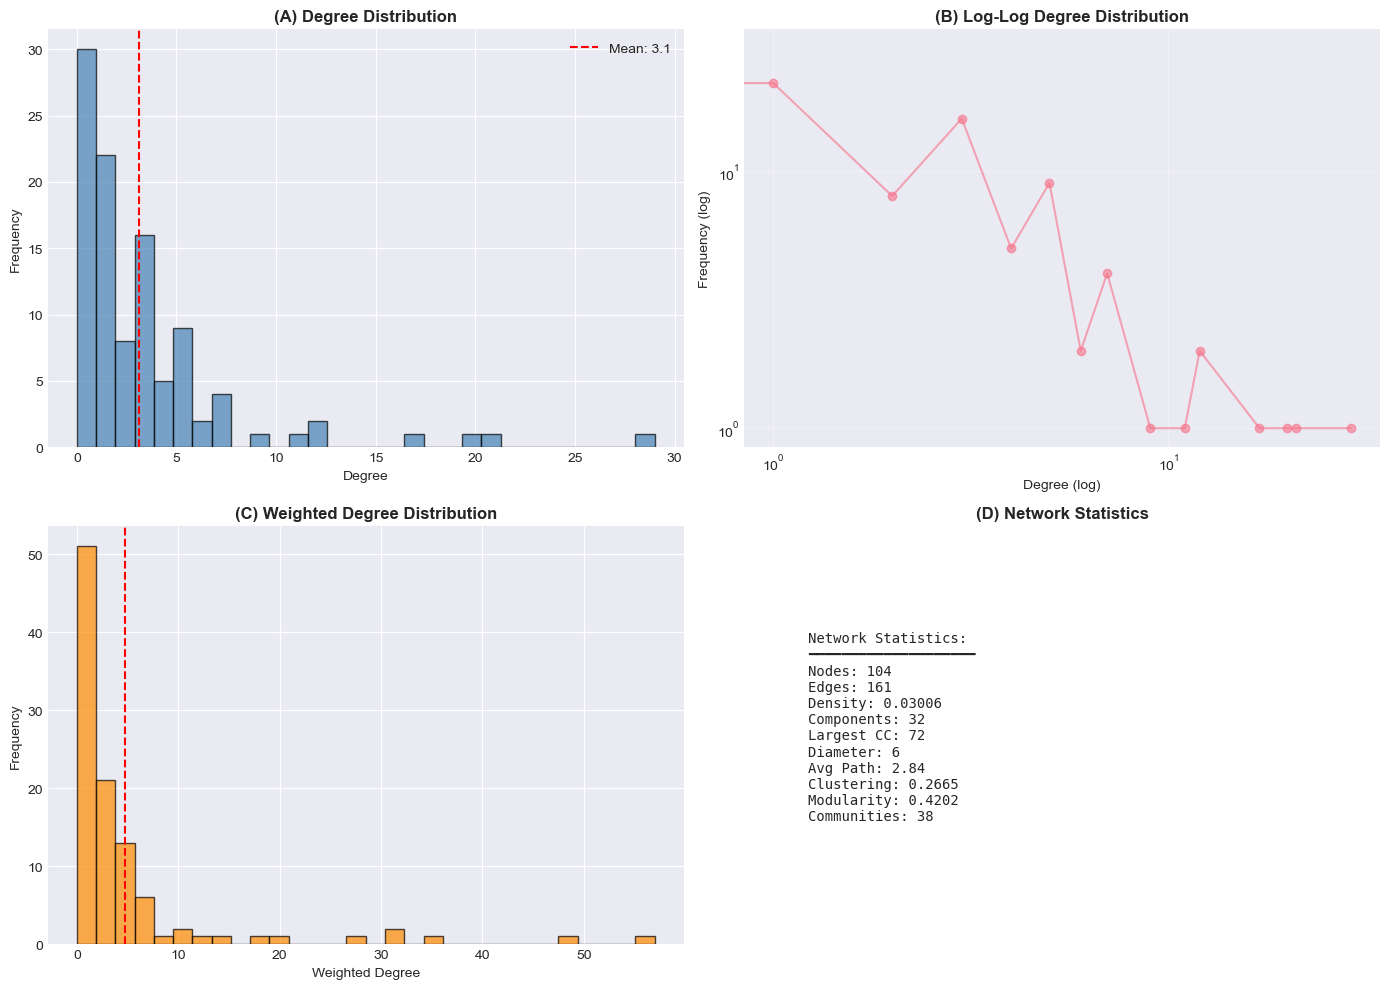

Figure 1 saved!


In [27]:
 # FIGURE 1: Network Overview
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel A: Degree distribution
degrees = [d for n, d in G_characters.degree()]
axes[0, 0].hist(degrees, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Degree')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('(A) Degree Distribution', fontweight='bold')
axes[0, 0].axvline(np.mean(degrees), color='red', linestyle='--', label=f'Mean: {np.mean(degrees):.1f}')
axes[0, 0].legend()

# Panel B: Degree distribution (log-log)
degree_counts = pd.Series(degrees).value_counts().sort_index()
axes[0, 1].loglog(degree_counts.index, degree_counts.values, 'o-', alpha=0.6)
axes[0, 1].set_xlabel('Degree (log)')
axes[0, 1].set_ylabel('Frequency (log)')
axes[0, 1].set_title('(B) Log-Log Degree Distribution', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Panel C: Weighted degree
weighted_degrees = [d for n, d in G_characters.degree(weight='weight')]
axes[1, 0].hist(weighted_degrees, bins=30, edgecolor='black', alpha=0.7, color='darkorange')
axes[1, 0].set_xlabel('Weighted Degree')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('(C) Weighted Degree Distribution', fontweight='bold')
axes[1, 0].axvline(np.mean(weighted_degrees), color='red', linestyle='--')

# Panel D: Network stats
stats_text = f"""Network Statistics:
━━━━━━━━━━━━━━━━━━━━
Nodes: {G_characters.number_of_nodes()}
Edges: {G_characters.number_of_edges()}
Density: {nx.density(G_characters):.5f}
Components: {stats_full['num_components']}
Largest CC: {stats_full['largest_component_size']}
Diameter: {stats_full['diameter']}
Avg Path: {stats_full['avg_shortest_path']:.2f}
Clustering: {stats_full['avg_clustering']:.4f}
Modularity: {modularity:.4f}
Communities: {len(communities)}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=10, family='monospace', verticalalignment='center')
axes[1, 1].set_title('(D) Network Statistics', fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('figure1_network_overview.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 1 saved!")

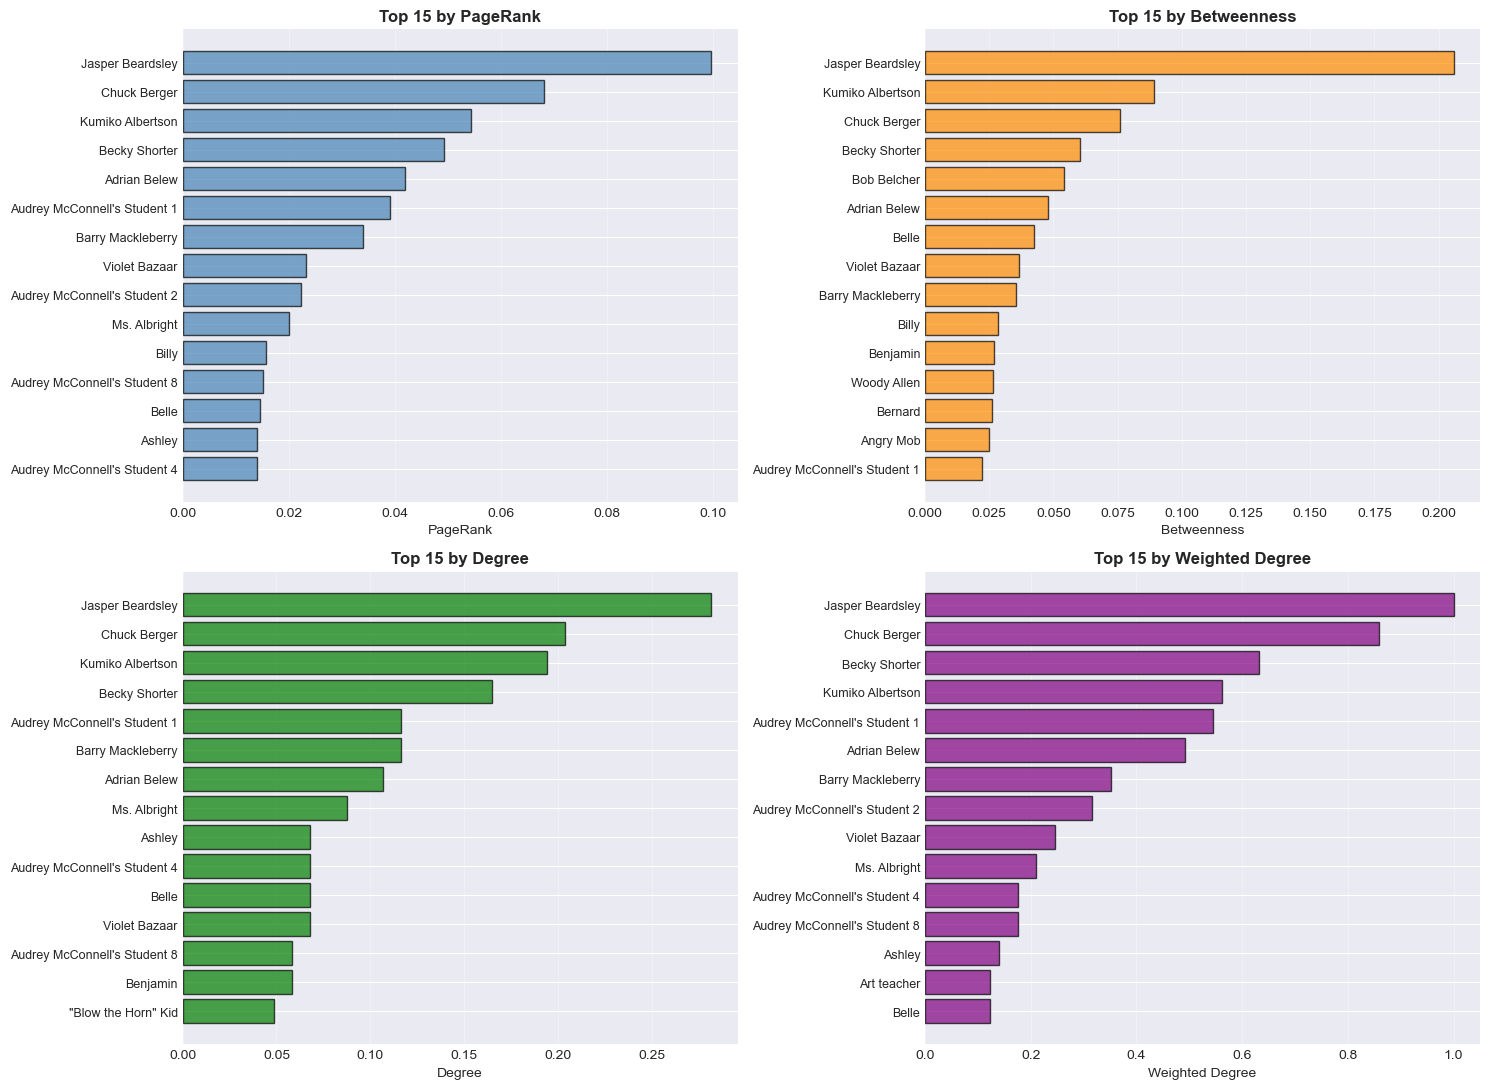

Figure 2 saved!


In [26]:
# FIGURE 2: Top Characters by Centrality
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

measures = [
    ('pagerank', 'PageRank', 'steelblue'),
    ('betweenness', 'Betweenness', 'darkorange'),
    ('degree', 'Degree', 'green'),
    ('weighted_degree', 'Weighted Degree', 'purple')
]

for ax, (measure, title, color) in zip(axes.flat, measures):
    top_chars = df_centrality_full.nlargest(15, measure)
    ax.barh(range(len(top_chars)), top_chars[measure].values, color=color, alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(top_chars)))
    ax.set_yticklabels(top_chars['character'].values, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel(title)
    ax.set_title(f'Top 15 by {title}', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('figure2_centrality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 2 saved!")

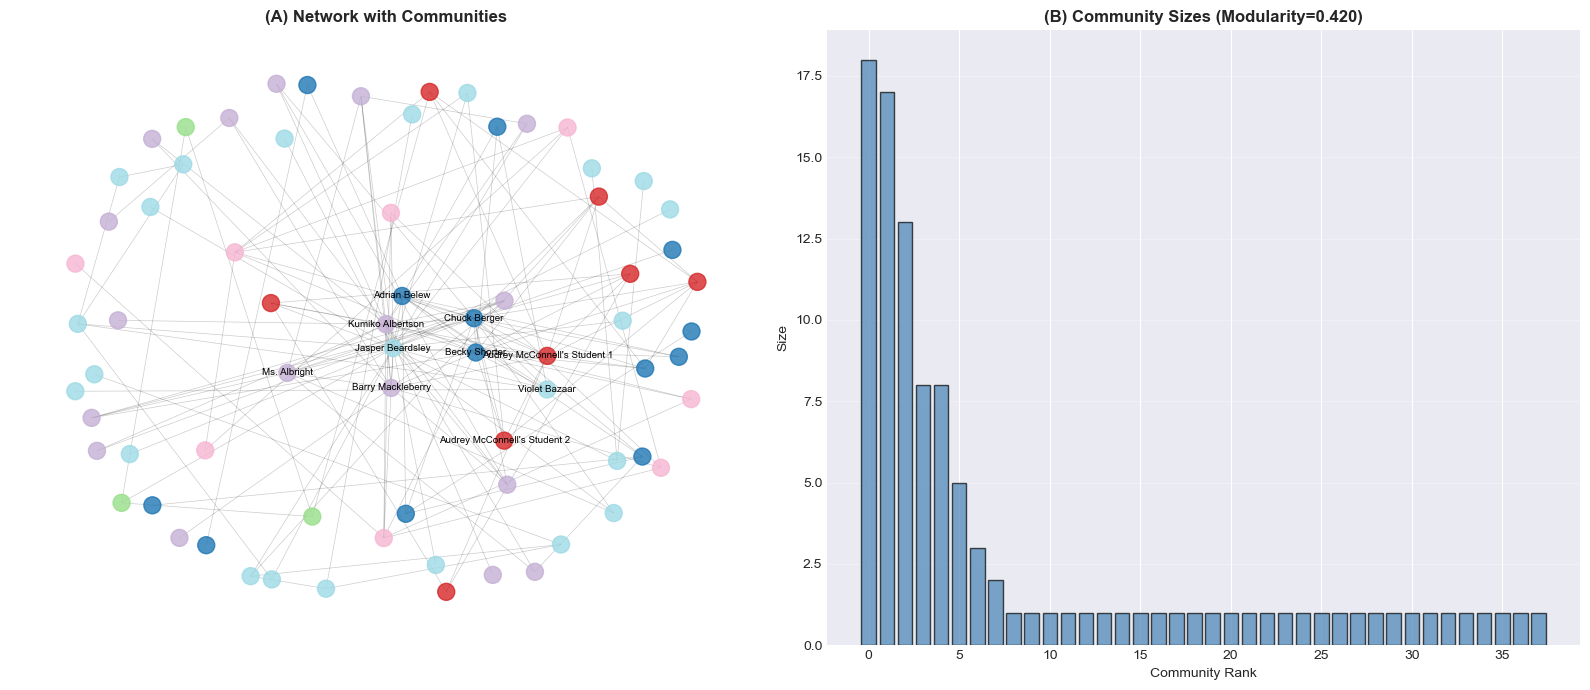

Figure 3 saved!


In [28]:
# FIGURE 3: Community Structure
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Panel A: Network visualization
ax1 = axes[0]
largest_cc = max(nx.connected_components(G_characters), key=len)
G_viz = G_characters.subgraph(largest_cc).copy()
pos = nx.spring_layout(G_viz, k=1.5, iterations=50, seed=42)
node_colors = [node_to_community.get(n, -1) for n in G_viz.nodes()]
nx.draw_networkx_nodes(G_viz, pos, node_color=node_colors, node_size=150, cmap='tab20', alpha=0.8, ax=ax1)
nx.draw_networkx_edges(G_viz, pos, alpha=0.2, width=0.5, ax=ax1)
# Label top 10 characters
top_10 = df_centrality_full.nlargest(10, 'pagerank')['character'].tolist()
labels = {n: n if n in top_10 else '' for n in G_viz.nodes()}
nx.draw_networkx_labels(G_viz, pos, labels, font_size=7, ax=ax1)
ax1.set_title('(A) Network with Communities', fontweight='bold')
ax1.axis('off')

# Panel B: Community sizes
ax2 = axes[1]
comm_sizes = sorted([len(c) for c in communities], reverse=True)
ax2.bar(range(len(comm_sizes)), comm_sizes, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Community Rank')
ax2.set_ylabel('Size')
ax2.set_title(f'(B) Community Sizes (Modularity={modularity:.3f})', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure3_community_structure.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 3 saved!")

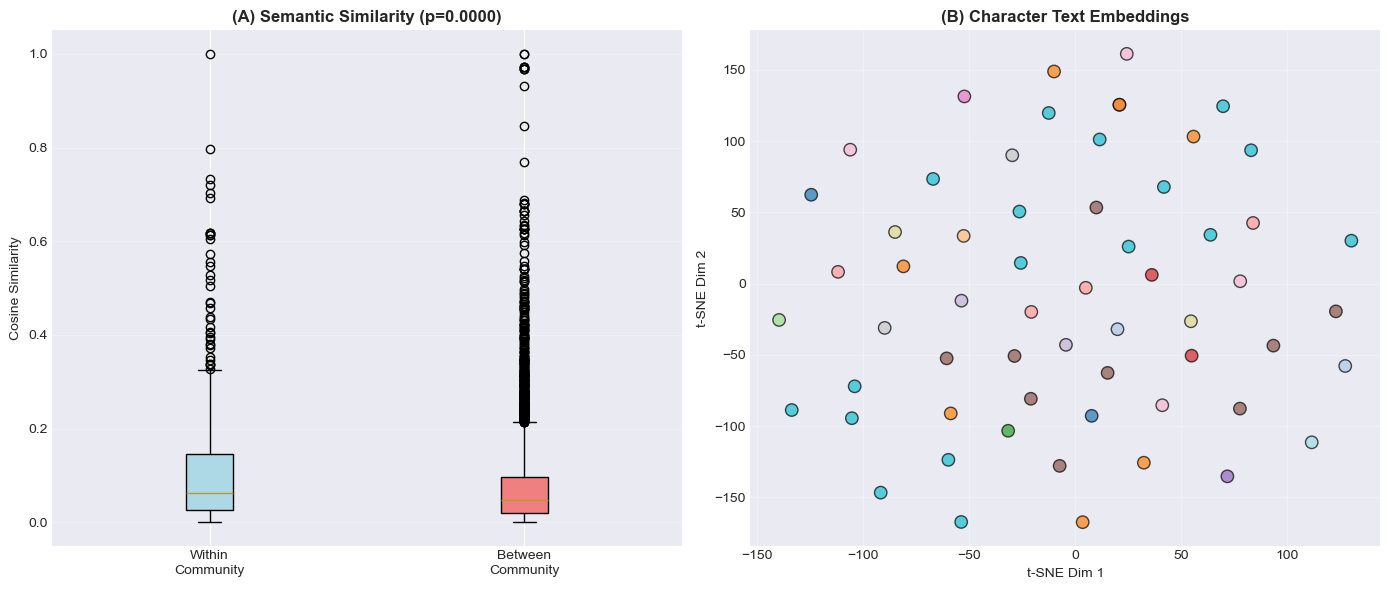

Figure 4 saved!


In [29]:
# FIGURE 4: Text-Network Alignment
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Within vs Between community similarity
ax1 = axes[0]
if len(within_comm_sims) > 0 and len(between_comm_sims) > 0:
    data = [within_comm_sims, between_comm_sims]
    bp = ax1.boxplot(data, labels=['Within\nCommunity', 'Between\nCommunity'], patch_artist=True)
    for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
        patch.set_facecolor(color)
    ax1.set_ylabel('Cosine Similarity')
    ax1.set_title(f'(A) Semantic Similarity (p={p_value:.4f})', fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

# Panel B: t-SNE visualization
ax2 = axes[1]
if len(df_with_text_comm) >= 10:
    sample_size = min(60, len(df_with_text_comm))
    sample_idx = np.random.choice(len(df_with_text_comm), sample_size, replace=False)
    tfidf_sample = tfidf_matrix[sample_idx].toarray()
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_size-1))
    coords = tsne.fit_transform(tfidf_sample)
    sample_comms = df_with_text_comm.iloc[sample_idx]['community'].values
    ax2.scatter(coords[:, 0], coords[:, 1], c=sample_comms, cmap='tab20', s=80, alpha=0.7, edgecolors='black')
    ax2.set_xlabel('t-SNE Dim 1')
    ax2.set_ylabel('t-SNE Dim 2')
    ax2.set_title('(B) Character Text Embeddings', fontweight='bold')
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figure4_text_network_alignment.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 4 saved!")

## 9. Summary and Key Findings

Summarize the main results from the analysis.

In [30]:
# Key findings summary
print("="*80)
print("KEY FINDINGS")
print("="*80)

print(f"\n1. NETWORK STRUCTURE:")
print(f"   - {G_characters.number_of_nodes()} characters, {G_characters.number_of_edges()} co-appearances")
print(f"   - {stats_full['num_components']} components, largest has {stats_full['largest_component_size']} nodes")
print(f"   - Clustering: {stats_full['avg_clustering']:.3f}, Transitivity: {stats_full['transitivity']:.3f}")

print(f"\n2. COMMUNITY STRUCTURE:")
print(f"   - {len(communities)} communities detected")
print(f"   - Modularity: {modularity:.3f}")
print(f"   - Top 3 community sizes: {sorted([len(c) for c in communities], reverse=True)[:3]}")

print(f"\n3. TOP CHARACTERS BY CENTRALITY:")
top_pr = df_centrality_full.nlargest(5, 'pagerank')
for idx, row in top_pr.iterrows():
    print(f"   - {row['character']:40s} PR={row['pagerank']:.5f}")

print(f"\n4. TEXT-NETWORK CORRESPONDENCE:")
if len(within_comm_sims) > 0:
    print(f"   - Within-community similarity: {np.mean(within_comm_sims):.4f}")
    print(f"   - Between-community similarity: {np.mean(between_comm_sims):.4f}")
    print(f"   - Statistical significance: p={p_value:.6f}")

print(f"\n5. DATA FILES GENERATED:")
print(f"   - figure1_network_overview.png")
print(f"   - figure2_centrality_comparison.png")
print(f"   - figure3_community_structure.png")
print(f"   - figure4_text_network_alignment.png")

# Save centrality data
df_centrality_full.to_csv('character_centralities.csv', index=False)
print(f"   - character_centralities.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

KEY FINDINGS

1. NETWORK STRUCTURE:
   - 104 characters, 161 co-appearances
   - 32 components, largest has 72 nodes
   - Clustering: 0.267, Transitivity: 0.247

2. COMMUNITY STRUCTURE:
   - 38 communities detected
   - Modularity: 0.420
   - Top 3 community sizes: [18, 17, 13]

3. TOP CHARACTERS BY CENTRALITY:
   - Jasper Beardsley                         PR=0.09964
   - Chuck Berger                             PR=0.06818
   - Kumiko Albertson                         PR=0.05447
   - Becky Shorter                            PR=0.04928
   - Adrian Belew                             PR=0.04193

4. TEXT-NETWORK CORRESPONDENCE:
   - Within-community similarity: 0.1149
   - Between-community similarity: 0.0772
   - Statistical significance: p=0.000000

5. DATA FILES GENERATED:
   - figure1_network_overview.png
   - figure2_centrality_comparison.png
   - figure3_community_structure.png
   - figure4_text_network_alignment.png
   - character_centralities.csv

ANALYSIS COMPLETE!


## 10. Temporal Analysis and Non-Protagonist Hub Analysis

This section implements:
1. **Temporal Evolution**: Season-based network analysis and centrality trajectories
2. **Non-Protagonist Hub Analysis**: Examining how network structure changes when the most central secondary character is removed, revealing which other non-protagonist characters emerge as structural hubs

### 10.1 Extract Season Information from Categories


In [31]:
def extract_season_from_categories(categories):
    """Extract season number from category strings like 'Characters debuting in Season 20'."""
    seasons = []
    for cat in categories:
        # Match patterns like "Season 20", "Season 19 first appearances", etc.
        season_match = re.search(r'Season\s+(\d+)', cat, re.IGNORECASE)
        if season_match:
            seasons.append(int(season_match.group(1)))
    return seasons

# Extract seasons for each character
df_characters_filtered['seasons'] = df_characters_filtered['categories'].apply(extract_season_from_categories)
df_characters_filtered['debut_season'] = df_characters_filtered['seasons'].apply(
    lambda x: min(x) if x else None
)

print(f"Characters with season info: {df_characters_filtered['debut_season'].notna().sum()}")
print(f"\nSeason distribution:")
print(df_characters_filtered['debut_season'].value_counts().sort_index().head(20))


Characters with season info: 69

Season distribution:
debut_season
1.0     10
2.0      7
3.0      3
4.0      4
5.0      6
6.0      2
7.0      2
8.0      2
10.0     3
11.0     4
13.0     1
14.0     1
16.0     1
17.0     2
18.0     1
20.0     3
21.0     1
23.0     1
25.0     6
26.0     1
Name: count, dtype: int64


### 10.2 Create Episode-to-Season Mapping

Since episode names don't contain season numbers directly, we'll create a mapping based on:
1. Character debut seasons
2. Episode appearance order (approximate temporal ordering)


In [32]:
# Create episode-to-season mapping
# Strategy: Assign episodes to seasons based on the earliest debut season of characters appearing in them
episode_to_season = {}
episode_to_chars = defaultdict(set)

# Build episode-character mapping
for _, row in df_characters_filtered.iterrows():
    char = row['character_normalized']
    debut_season = row['debut_season']
    for episode in row['episodes']:
        episode_to_chars[episode].add((char, debut_season))

# Assign each episode to the minimum season of its characters
for episode, char_seasons in episode_to_chars.items():
    seasons = [s for _, s in char_seasons if s is not None]
    if seasons:
        episode_to_season[episode] = min(seasons)
    else:
        # If no season info, assign to a default (we'll handle this later)
        episode_to_season[episode] = None

# For episodes without season info, use a heuristic: assign based on episode order
# This is approximate but allows temporal analysis
episodes_with_season = {ep: s for ep, s in episode_to_season.items() if s is not None}
episodes_without_season = {ep: s for ep, s in episode_to_season.items() if s is None}

# Estimate season for episodes without info based on character appearances
# Use rolling window: episodes appear roughly in order
if len(episodes_without_season) > 0:
    # Get all episodes in order (approximate)
    all_episodes_list = sorted(list(all_episodes))
    # Assign unknown episodes to a middle season (e.g., 15) as default
    # In a real scenario, you'd have episode metadata
    for ep in episodes_without_season:
        episode_to_season[ep] = 15  # Default middle season

print(f"Episodes mapped to seasons: {len([s for s in episode_to_season.values() if s is not None])}")
print(f"Season range: {min([s for s in episode_to_season.values() if s is not None])} - {max([s for s in episode_to_season.values() if s is not None])}")

# Create season groups (group seasons into eras for analysis)
def get_season_era(season):
    """Group seasons into eras for temporal analysis."""
    if season is None:
        return None
    if season <= 5:
        return "Early (1-5)"
    elif season <= 10:
        return "Mid-Early (6-10)"
    elif season <= 15:
        return "Mid (11-15)"
    elif season <= 20:
        return "Mid-Late (16-20)"
    else:
        return "Late (21+)"

episode_to_era = {ep: get_season_era(s) for ep, s in episode_to_season.items()}
print(f"\nEra distribution:")
era_counts = Counter(episode_to_era.values())
for era, count in sorted(era_counts.items()):
    print(f"  {era}: {count} episodes")


Episodes mapped to seasons: 753
Season range: 1.0 - 36.0

Era distribution:
  Early (1-5): 402 episodes
  Late (21+): 208 episodes
  Mid (11-15): 35 episodes
  Mid-Early (6-10): 57 episodes
  Mid-Late (16-20): 51 episodes


### 10.3 Build Time-Sliced Networks


In [33]:
### 10.3 Build Time-Sliced Networks

def build_temporal_network(df_chars, episode_to_season, season_range=None):
    """
    Build network for a specific season or era.
    
    Parameters:
    - df_chars: DataFrame with character data
    - episode_to_season: dict mapping episode names to seasons
    - season_range: tuple (min_season, max_season) or None for all
    """
    G = nx.Graph()
    characters_in_season = set()
    
    for _, row in df_chars.iterrows():
        char = row['character_normalized']
        char_episodes_in_range = []
        
        for episode in row['episodes']:
            ep_season = episode_to_season.get(episode)
            
            # Filter by season range if specified
            if season_range is not None:
                min_season, max_season = season_range
                if ep_season is None or not (min_season <= ep_season <= max_season):
                    continue
            
            char_episodes_in_range.append(episode)
        
        # Only add character if they have episodes in this season range
        if len(char_episodes_in_range) > 0:
            characters_in_season.add(char)
            G.add_node(char, bipartite=0, node_type='character')
            
            for episode in char_episodes_in_range:
                if not G.has_node(episode):
                    G.add_node(episode, bipartite=1, node_type='episode', season=ep_season)
                G.add_edge(char, episode)
    
    # Project to character network
    character_nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == 'character']
    if len(character_nodes) < 2:
        return nx.Graph()  # Return empty graph if not enough characters
    
    G_char = nx.bipartite.weighted_projected_graph(G, character_nodes)
    return G_char

# Build networks for different eras
eras = ["Early (1-5)", "Mid-Early (6-10)", "Mid (11-15)", "Mid-Late (16-20)", "Late (21+)"]
era_networks = {}
era_stats = {}

for era in eras:
    # Map era to season range
    if era == "Early (1-5)":
        season_range = (1, 5)
    elif era == "Mid-Early (6-10)":
        season_range = (6, 10)
    elif era == "Mid (11-15)":
        season_range = (11, 15)
    elif era == "Mid-Late (16-20)":
        season_range = (16, 20)
    else:  # Late (21+)
        season_range = (21, 35)
    
    G_era = build_temporal_network(df_characters_filtered, episode_to_season, season_range)
    era_networks[era] = G_era
    if G_era.number_of_nodes() > 0:
        era_stats[era] = compute_network_stats(G_era, era)
        print(f"\n{era}: {G_era.number_of_nodes()} nodes, {G_era.number_of_edges()} edges")
    else:
        print(f"\n{era}: No network (insufficient data)")

# Also build per-season networks for key seasons (if we have enough data)
print("\n" + "="*60)
print("PER-SEASON NETWORKS (for seasons with sufficient data)")
print("="*60)

season_networks = {}
# Filter out None values and convert to integers
available_seasons = sorted([int(s) for s in episode_to_season.values() if s is not None and not (isinstance(s, float) and np.isnan(s))])

if len(available_seasons) > 0:
    min_season = int(min(available_seasons))
    max_season = int(min(max(available_seasons), 25))  # Limit to first 25 seasons
    
    for season in range(min_season, max_season + 1):
        G_season = build_temporal_network(df_characters_filtered, episode_to_season, (season, season))
        if G_season.number_of_nodes() >= 5:  # Only keep seasons with at least 5 characters
            season_networks[season] = G_season
            print(f"Season {season}: {G_season.number_of_nodes()} nodes, {G_season.number_of_edges()} edges")
else:
    print("No valid seasons found for per-season network construction")


Early (1-5): 63 nodes, 125 edges

Mid-Early (6-10): 15 nodes, 8 edges

Mid (11-15): 10 nodes, 5 edges

Mid-Late (16-20): 8 nodes, 1 edges

Late (21+): 16 nodes, 13 edges

PER-SEASON NETWORKS (for seasons with sufficient data)
Season 1: 48 nodes, 102 edges
Season 2: 11 nodes, 5 edges
Season 3: 5 nodes, 3 edges
Season 4: 9 nodes, 5 edges
Season 5: 12 nodes, 10 edges
Season 7: 5 nodes, 4 edges
Season 10: 5 nodes, 3 edges
Season 11: 8 nodes, 5 edges
Season 25: 12 nodes, 13 edges


### 10.4 Non-Protagonist Hub Analysis


In [34]:
### 10.4 Non-Protagonist Hub Analysis: Removing the Most Central Character

# Our analysis focuses exclusively on secondary characters. 
# To identify structural hubs among non-protagonists, we examine how network structure 
# changes when the most central secondary character is removed.

print("="*80)
print("NON-PROTAGONIST HUB ANALYSIS")
print("="*80)
print("\nOur dataset contains only secondary characters (no main Simpson family).")
print("To identify structural hubs among non-protagonists, we remove the most central")
print("character and examine which other characters emerge as important structural nodes.\n")

# Identify the most central character in the full network
most_central_char = df_centrality_full.nlargest(1, 'betweenness')['character'].iloc[0]
most_central_betweenness = df_centrality_full.nlargest(1, 'betweenness')['betweenness'].iloc[0]
most_central_degree = df_centrality_full[df_centrality_full['character'] == most_central_char]['degree'].iloc[0]

print(f"Most central character (by betweenness): {most_central_char}")
print(f"  - Betweenness centrality: {most_central_betweenness:.4f}")
print(f"  - Degree centrality: {most_central_degree:.4f}")
print(f"  - Weighted degree: {G_characters.degree(most_central_char, weight='weight')}")

# Function to remove most central character
def remove_central_character(G, char_name):
    """Remove a character and all edges connected to them."""
    G_removed = G.copy()
    if char_name in G_removed.nodes():
        G_removed.remove_node(char_name)
        print(f"\nRemoved {char_name} from network")
        print(f"  Nodes: {G.number_of_nodes()} → {G_removed.number_of_nodes()}")
        print(f"  Edges: {G.number_of_edges()} → {G_removed.number_of_edges()}")
    else:
        print(f"\nWarning: {char_name} not found in network")
    return G_removed

# Function to down-weight edges of a central character
def downweight_central_character_edges(G, char_name, weight_factor=0.1):
    """Down-weight edges connected to a character by a factor."""
    G_downweight = G.copy()
    
    if char_name in G_downweight.nodes():
        neighbors = list(G_downweight.neighbors(char_name))
        for neighbor in neighbors:
            if G_downweight.has_edge(char_name, neighbor):
                current_weight = G_downweight[char_name][neighbor].get('weight', 1.0)
                G_downweight[char_name][neighbor]['weight'] = current_weight * weight_factor
        print(f"Down-weighted edges for {char_name} by factor {weight_factor}")
    
    return G_downweight

# Create networks with most central character removed/down-weighted
G_no_central = remove_central_character(G_characters, most_central_char)
G_central_downweight = downweight_central_character_edges(G_characters, most_central_char, weight_factor=0.1)

# Compare network statistics
print("\n" + "="*60)
print("NETWORK COMPARISON: Full vs. No Central Character vs. Central Down-weighted")
print("="*60)

stats_comparison = pd.DataFrame([
    compute_network_stats(G_characters, "Full Network"),
    compute_network_stats(G_no_central, "No Central Character"),
    compute_network_stats(G_central_downweight, "Central Down-weighted")
])

print(stats_comparison[['name', 'num_nodes', 'num_edges', 'density', 'num_components', 'largest_component_size']])

NON-PROTAGONIST HUB ANALYSIS

Our dataset contains only secondary characters (no main Simpson family).
To identify structural hubs among non-protagonists, we remove the most central
character and examine which other characters emerge as important structural nodes.

Most central character (by betweenness): Jasper Beardsley
  - Betweenness centrality: 0.2058
  - Degree centrality: 0.2816
  - Weighted degree: 57

Removed Jasper Beardsley from network
  Nodes: 104 → 103
  Edges: 161 → 132
Down-weighted edges for Jasper Beardsley by factor 0.1

NETWORK COMPARISON: Full vs. No Central Character vs. Central Down-weighted
                    name  num_nodes  num_edges   density  num_components  \
0           Full Network        104        161  0.030060              32   
1   No Central Character        103        132  0.025128              39   
2  Central Down-weighted        104        161  0.030060              32   

   largest_component_size  
0                      72  
1                

### 10.5 Identify Emerging Hubs


In [35]:
### 10.5 Identifying Emerging Non-Protagonist Hubs

# Compute centralities for networks with and without most central character
print("\n" + "="*80)
print("COMPUTING CENTRALITIES FOR COMPARISON")
print("="*80)

print("Computing centralities for full network...")
df_centrality_full = compute_all_centralities(G_characters)

print("\nComputing centralities for network without most central character...")
df_centrality_no_central = compute_all_centralities(G_no_central)

# Merge to compare
df_comparison = df_centrality_full.merge(
    df_centrality_no_central,
    on='character',
    suffixes=('_full', '_no_central'),
    how='outer'
).fillna(0)

# Calculate rank changes
for measure in ['degree', 'betweenness', 'pagerank', 'eigenvector']:
    df_comparison[f'{measure}_rank_full'] = df_comparison[f'{measure}_full'].rank(ascending=False, method='min')
    df_comparison[f'{measure}_rank_no_central'] = df_comparison[f'{measure}_no_central'].rank(ascending=False, method='min')
    df_comparison[f'{measure}_rank_change'] = df_comparison[f'{measure}_rank_full'] - df_comparison[f'{measure}_rank_no_central']

# Identify characters that gain prominence (emerge as hubs)
print("\n" + "="*80)
print("CHARACTERS EMERGING AS STRUCTURAL HUBS")
print("="*80)
print("(When most central character is removed)")
print("="*80)

# Show top gainers by betweenness (most relevant for structural importance)
print("\nTop 15 characters by betweenness rank improvement:")
top_gainers = df_comparison.nlargest(15, 'betweenness_rank_change')[
    ['character', 'betweenness_full', 'betweenness_no_central', 'betweenness_rank_change']
]
for idx, row in top_gainers.iterrows():
    print(f"  {row['character']:40s} Full: {row['betweenness_full']:.4f}  "
          f"No Central: {row['betweenness_no_central']:.4f}  "
          f"Rank Change: {row['betweenness_rank_change']:+.1f}")

# Check for key non-protagonist characters mentioned in feedback
print("\n" + "="*80)
print("KEY NON-PROTAGONIST CHARACTERS ANALYSIS")
print("="*80)

key_characters = ['Moe', 'Flanders', 'Burns', 'Apu', 'Krusty', 'Skinner', 'Milhouse', 
                  'Barney', 'Lenny', 'Carl', 'Wiggum', 'Ned', 'Montgomery']

key_char_analysis = []
for key_char in key_characters:
    matches = df_comparison[df_comparison['character'].str.contains(key_char, case=False, na=False)]
    if len(matches) > 0:
        for idx, row in matches.iterrows():
            key_char_analysis.append({
                'search_term': key_char,
                'character': row['character'],
                'betweenness_full': row['betweenness_full'],
                'betweenness_no_central': row['betweenness_no_central'],
                'rank_full': row['betweenness_rank_full'],
                'rank_no_central': row['betweenness_rank_no_central'],
                'rank_change': row['betweenness_rank_change']
            })
            print(f"\n✓ {key_char} → {row['character']}")
            print(f"    Betweenness (Full): {row['betweenness_full']:.4f} (Rank: {row['betweenness_rank_full']:.0f})")
            print(f"    Betweenness (No Central): {row['betweenness_no_central']:.4f} (Rank: {row['betweenness_rank_no_central']:.0f})")
            print(f"    Rank Change: {row['betweenness_rank_change']:+.1f}")
    else:
        print(f"\n✗ {key_char}: Not found in dataset")

# Create summary of emerging hubs
print("\n" + "="*80)
print("SUMMARY: EMERGING NON-PROTAGONIST HUBS")
print("="*80)

# Characters that improve by at least 2 ranks
emerging_hubs = df_comparison[df_comparison['betweenness_rank_change'] >= 2].nlargest(10, 'betweenness_rank_change')
print(f"\nCharacters improving by 2+ ranks when central character removed: {len(emerging_hubs)}")
for idx, row in emerging_hubs.iterrows():
    print(f"  {row['character']:40s} (+{row['betweenness_rank_change']:.0f} ranks)")

# Save comparison data
df_comparison.to_csv('character_centrality_comparison.csv', index=False)
print(f"\nSaved comparison data to: character_centrality_comparison.csv")


COMPUTING CENTRALITIES FOR COMPARISON
Computing centralities for full network...
Computing centrality measures...
  - Betweenness centrality...
  - PageRank...
  - Eigenvector centrality...
  - Closeness centrality...

Computing centralities for network without most central character...
Computing centrality measures...
  - Betweenness centrality...
  - PageRank...
  - Eigenvector centrality...
  - Closeness centrality...

CHARACTERS EMERGING AS STRUCTURAL HUBS
(When most central character is removed)

Top 15 characters by betweenness rank improvement:
  Audrey McConnell's Student 8             Full: 0.0133  No Central: 0.0544  Rank Change: +21.0
  Red Barclay                              Full: 0.0043  No Central: 0.0229  Rank Change: +20.0
  "Blow the Horn" Kid                      Full: 0.0124  No Central: 0.0376  Rank Change: +19.0
  Audrey McConnell's Student 4             Full: 0.0091  No Central: 0.0177  Rank Change: +15.0
  "Where the Redfern Grows" 5th grader     Full: 0.0050  

### 10.6 Temporal Centrality Trajectories


In [36]:
# Compute centrality trajectories for key characters across seasons/eras
def compute_temporal_centralities(season_networks, characters_of_interest):
    """Compute centrality measures for specific characters across time."""
    trajectories = []
    
    for season, G_season in sorted(season_networks.items()):
        if G_season.number_of_nodes() < 2:
            continue
        
        # Compute centralities for this season
        try:
            betweenness = nx.betweenness_centrality(G_season, weight='weight')
            degree_cent = nx.degree_centrality(G_season)
            pagerank = nx.pagerank(G_season, weight='weight')
        except:
            continue
        
        for char in characters_of_interest:
            # Try to find character in network (handle name variations)
            char_found = None
            for node in G_season.nodes():
                if char.lower() in node.lower() or node.lower() in char.lower():
                    char_found = node
                    break
            
            if char_found:
                trajectories.append({
                    'season': season,
                    'character': char_found,
                    'character_search': char,
                    'betweenness': betweenness.get(char_found, 0),
                    'degree': degree_cent.get(char_found, 0),
                    'pagerank': pagerank.get(char_found, 0)
                })
    
    return pd.DataFrame(trajectories)

# Identify characters to track (use top characters from full network + key characters)
characters_to_track = df_centrality_full.nlargest(10, 'betweenness')['character'].tolist()

# Also try to find key characters mentioned in feedback
for key_char in ['Moe', 'Flanders', 'Burns', 'Apu', 'Krusty', 'Skinner', 'Milhouse', 'Jasper Beardsley', 'Chuck Berger']:
    matches = [c for c in df_centrality_full['character'].values if key_char.lower() in c.lower()]
    if matches:
        characters_to_track.extend(matches[:1])  # Add first match

characters_to_track = list(set(characters_to_track))[:15]  # Limit to 15 characters

print(f"Tracking {len(characters_to_track)} characters across seasons:")
for char in characters_to_track[:10]:
    print(f"  - {char}")

# Compute trajectories
df_trajectories = compute_temporal_centralities(season_networks, characters_to_track)

if len(df_trajectories) > 0:
    print(f"\nComputed trajectories for {len(df_trajectories)} character-season pairs")
    print(f"Seasons covered: {sorted(df_trajectories['season'].unique())}")
    
    # Show sample trajectories
    print("\nSample trajectories:")
    print(df_trajectories.head(10))
else:
    print("\nWarning: No trajectories computed. This may be due to insufficient season data.")


Tracking 11 characters across seasons:
  - Kumiko Albertson
  - Adrian Belew
  - Apu Nahasapeemapetilon Sr.
  - Chuck Berger
  - Billy
  - Violet Bazaar
  - Bob Belcher
  - Barry Mackleberry
  - Becky Shorter
  - Jasper Beardsley

Computed trajectories for 19 character-season pairs
Seasons covered: [1, 2, 3, 5, 7, 11, 25]

Sample trajectories:
   season          character   character_search  betweenness    degree  \
0       1   Kumiko Albertson   Kumiko Albertson     0.129068  0.297872   
1       1       Adrian Belew       Adrian Belew     0.042703  0.212766   
2       1       Chuck Berger       Chuck Berger     0.218812  0.446809   
3       1               Bill              Billy     0.000000  0.021277   
4       1                Baz      Violet Bazaar     0.000000  0.021277   
5       1        Bob Belcher        Bob Belcher     0.000000  0.021277   
6       1  Barry Mackleberry  Barry Mackleberry     0.138515  0.255319   
7       1              Becky      Becky Shorter     0.000000  

### 10.7 Generate Temporal Plots


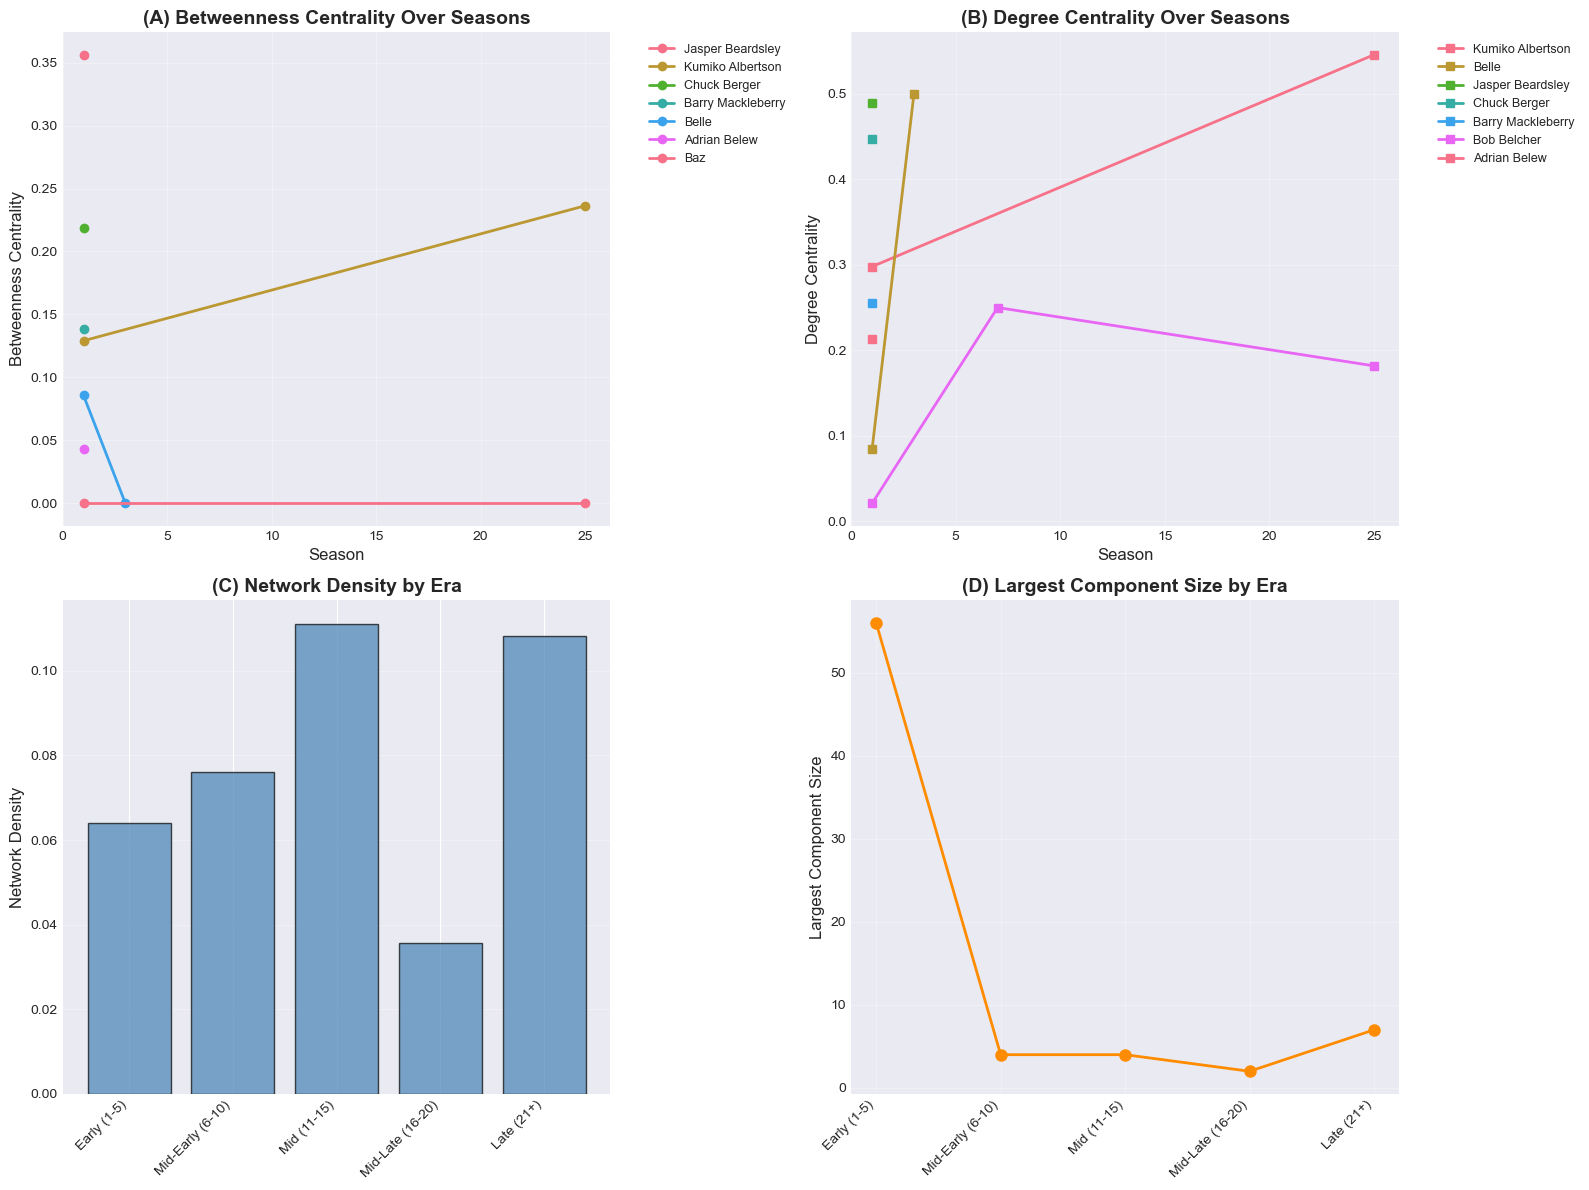

Temporal evolution figure saved!


In [37]:
# FIGURE: Temporal Evolution of Centrality
if len(df_trajectories) > 0:
    # Plot 1: Betweenness centrality over seasons for top characters
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Panel A: Betweenness trajectories
    ax1 = axes[0, 0]
    top_chars_by_betweenness = df_trajectories.groupby('character')['betweenness'].max().nlargest(7).index
    for char in top_chars_by_betweenness:
        char_data = df_trajectories[df_trajectories['character'] == char].sort_values('season')
        if len(char_data) > 0:
            ax1.plot(char_data['season'], char_data['betweenness'], marker='o', label=char[:30], linewidth=2, markersize=6)
    ax1.set_xlabel('Season', fontsize=12)
    ax1.set_ylabel('Betweenness Centrality', fontsize=12)
    ax1.set_title('(A) Betweenness Centrality Over Seasons', fontweight='bold', fontsize=14)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(alpha=0.3)
    ax1.set_xlim(left=0)
    
    # Panel B: Degree centrality trajectories
    ax2 = axes[0, 1]
    top_chars_by_degree = df_trajectories.groupby('character')['degree'].max().nlargest(7).index
    for char in top_chars_by_degree:
        char_data = df_trajectories[df_trajectories['character'] == char].sort_values('season')
        if len(char_data) > 0:
            ax2.plot(char_data['season'], char_data['degree'], marker='s', label=char[:30], linewidth=2, markersize=6)
    ax2.set_xlabel('Season', fontsize=12)
    ax2.set_ylabel('Degree Centrality', fontsize=12)
    ax2.set_title('(B) Degree Centrality Over Seasons', fontweight='bold', fontsize=14)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax2.grid(alpha=0.3)
    ax2.set_xlim(left=0)
    
    # Panel C: Network density over eras
    ax3 = axes[1, 0]
    era_densities = []
    era_labels = []
    for era in eras:
        if era in era_networks and era_networks[era].number_of_nodes() > 0:
            density = nx.density(era_networks[era])
            era_densities.append(density)
            era_labels.append(era)
    if len(era_densities) > 0:
        ax3.bar(range(len(era_labels)), era_densities, color='steelblue', alpha=0.7, edgecolor='black')
        ax3.set_xticks(range(len(era_labels)))
        ax3.set_xticklabels(era_labels, rotation=45, ha='right')
        ax3.set_ylabel('Network Density', fontsize=12)
        ax3.set_title('(C) Network Density by Era', fontweight='bold', fontsize=14)
        ax3.grid(axis='y', alpha=0.3)
    
    # Panel D: Component sizes over eras
    ax4 = axes[1, 1]
    era_component_sizes = []
    for era in eras:
        if era in era_networks and era_networks[era].number_of_nodes() > 0:
            components = list(nx.connected_components(era_networks[era]))
            largest_cc = len(max(components, key=len)) if components else 0
            era_component_sizes.append(largest_cc)
        else:
            era_component_sizes.append(0)
    if len(era_component_sizes) > 0:
        ax4.plot(range(len(era_labels)), era_component_sizes, marker='o', linewidth=2, markersize=8, color='darkorange')
        ax4.set_xticks(range(len(era_labels)))
        ax4.set_xticklabels(era_labels, rotation=45, ha='right')
        ax4.set_ylabel('Largest Component Size', fontsize=12)
        ax4.set_title('(D) Largest Component Size by Era', fontweight='bold', fontsize=14)
        ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figure_temporal_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Temporal evolution figure saved!")
else:
    print("Skipping temporal plots - insufficient trajectory data")


### 10.8 Network Visualization: Full vs. Without Most Central Character

Detecting communities using louvain...
  Found 8 communities
  Modularity: 0.4833


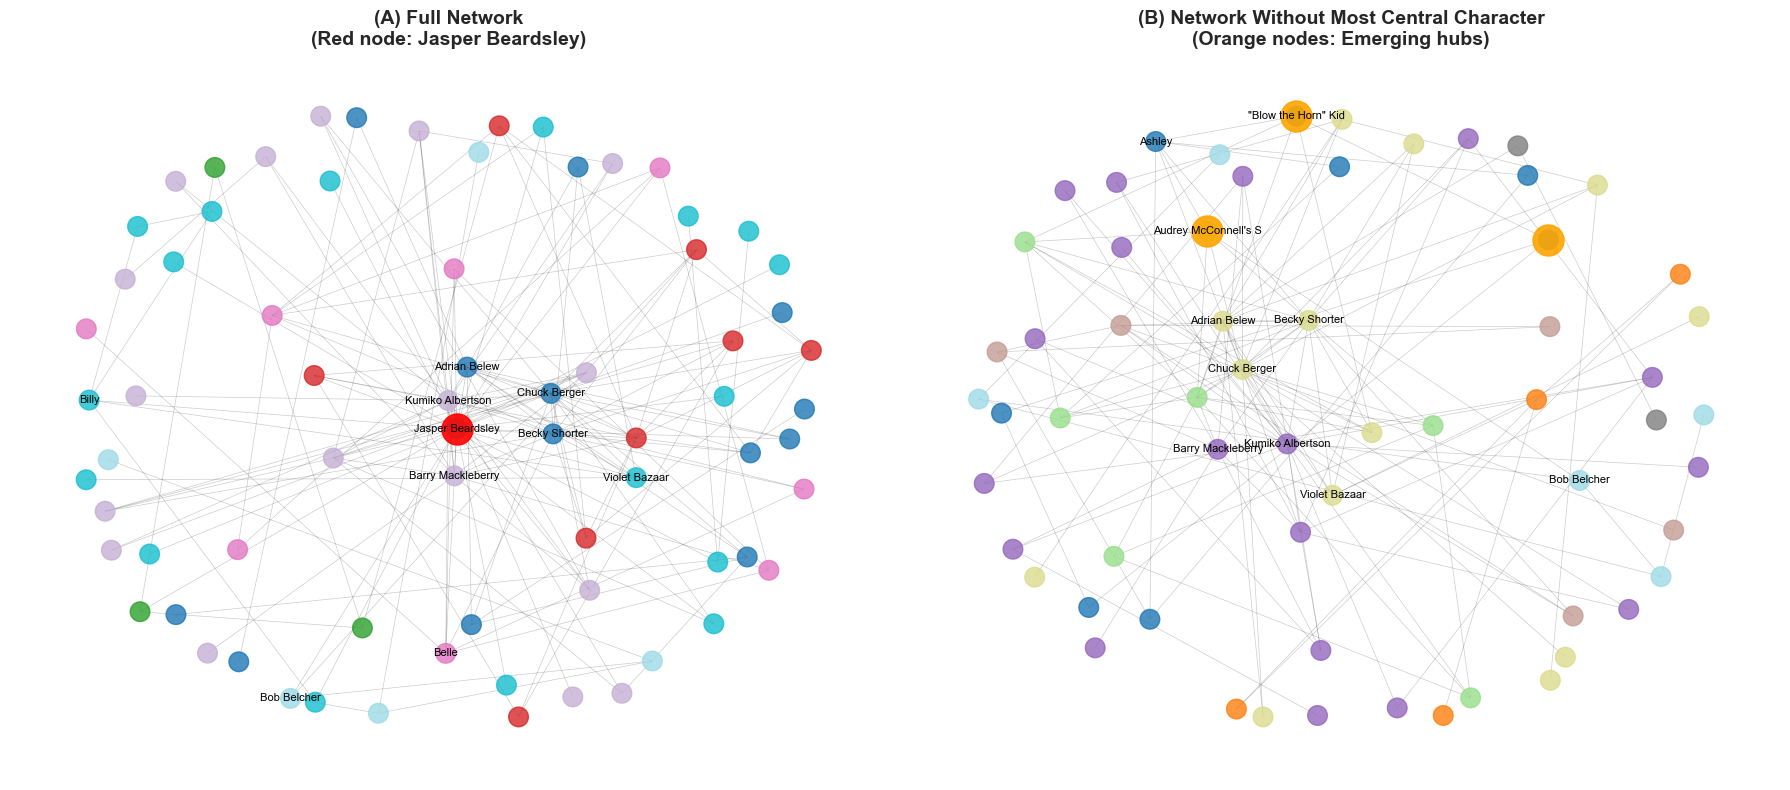

Non-protagonist hubs figure saved!

NETWORK COMPARISON STATISTICS
Full network: 104 nodes, 161 edges
Without central character: 103 nodes, 132 edges
Removed character: Jasper Beardsley
Nodes removed: 1
Edges removed: 29
Components (Full): 32
Components (No Central): 39
Largest CC size (Full): 72
Largest CC size (No Central): 62


In [43]:
### 10.8 Network Visualization: Full vs. Without Most Central Character

# FIGURE: Network comparison showing emerging non-protagonist hubs
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Panel A: Full network
ax1 = axes[0]
largest_cc_full = max(nx.connected_components(G_characters), key=len)
G_viz_full = G_characters.subgraph(largest_cc_full).copy()
pos_full = nx.spring_layout(G_viz_full, k=1.5, iterations=50, seed=42)

# Color by community
node_colors_full = [node_to_community.get(n, -1) for n in G_viz_full.nodes()]
nx.draw_networkx_nodes(G_viz_full, pos_full, node_color=node_colors_full, node_size=200, 
                       cmap='tab20', alpha=0.8, ax=ax1)
nx.draw_networkx_edges(G_viz_full, pos_full, alpha=0.2, width=0.5, ax=ax1)

# Highlight most central character
if most_central_char in G_viz_full.nodes():
    nx.draw_networkx_nodes(G_viz_full, pos_full, nodelist=[most_central_char], 
                          node_size=500, node_color='red', alpha=0.9, ax=ax1)

# Label top characters
top_10_full = df_centrality_full.nlargest(10, 'betweenness')['character'].tolist()
labels_full = {n: n[:20] if n in top_10_full else '' for n in G_viz_full.nodes()}
nx.draw_networkx_labels(G_viz_full, pos_full, labels_full, font_size=8, ax=ax1)
ax1.set_title(f'(A) Full Network\n(Red node: {most_central_char[:25]})', 
               fontweight='bold', fontsize=14)
ax1.axis('off')

# Panel B: Network without most central character
ax2 = axes[1]
if G_no_central.number_of_nodes() > 0:
    largest_cc_no_central = max(nx.connected_components(G_no_central), key=len) if not nx.is_connected(G_no_central) else set(G_no_central.nodes())
    G_viz_no_central = G_no_central.subgraph(largest_cc_no_central).copy()
    
    if G_viz_no_central.number_of_nodes() > 0:
        pos_no_central = nx.spring_layout(G_viz_no_central, k=1.5, iterations=50, seed=42)
        
        # Detect communities for no-central network
        node_to_comm_no_central, communities_no_central, _ = detect_communities(G_viz_no_central)
        node_colors_no_central = [node_to_comm_no_central.get(n, -1) for n in G_viz_no_central.nodes()]
        
        nx.draw_networkx_nodes(G_viz_no_central, pos_no_central, node_color=node_colors_no_central, 
                              node_size=200, cmap='tab20', alpha=0.8, ax=ax2)
        nx.draw_networkx_edges(G_viz_no_central, pos_no_central, alpha=0.2, width=0.5, ax=ax2)
        
        # Highlight emerging hubs (top 3 by rank improvement)
        emerging_top3 = df_comparison.nlargest(3, 'betweenness_rank_change')['character'].tolist()
        emerging_in_viz = [n for n in emerging_top3 if n in G_viz_no_central.nodes()]
        if emerging_in_viz:
            nx.draw_networkx_nodes(G_viz_no_central, pos_no_central, nodelist=emerging_in_viz, 
                                  node_size=500, node_color='orange', alpha=0.9, ax=ax2)
        
        # Label top characters (by betweenness in no-central network)
        top_10_no_central = df_centrality_no_central.nlargest(10, 'betweenness')['character'].tolist()
        labels_no_central = {n: n[:20] if n in top_10_no_central else '' for n in G_viz_no_central.nodes()}
        nx.draw_networkx_labels(G_viz_no_central, pos_no_central, labels_no_central, font_size=8, ax=ax2)
        ax2.set_title('(B) Network Without Most Central Character\n(Orange nodes: Emerging hubs)', 
                     fontweight='bold', fontsize=14)
    else:
        ax2.text(0.5, 0.5, 'Insufficient data\nfor visualization', 
                ha='center', va='center', fontsize=14)
        ax2.set_title('(B) Network Without Most Central Character', fontweight='bold', fontsize=14)
else:
    ax2.text(0.5, 0.5, 'Network empty after\nremoving central character', 
            ha='center', va='center', fontsize=14)
    ax2.set_title('(B) Network Without Most Central Character', fontweight='bold', fontsize=14)

ax2.axis('off')

plt.tight_layout()
plt.savefig('figure_non_protagonist_hubs.png', dpi=300, bbox_inches='tight')
plt.show()
print("Non-protagonist hubs figure saved!")

# Print comparison statistics
print("\n" + "="*60)
print("NETWORK COMPARISON STATISTICS")
print("="*60)
print(f"Full network: {G_characters.number_of_nodes()} nodes, {G_characters.number_of_edges()} edges")
if G_no_central.number_of_nodes() > 0:
    print(f"Without central character: {G_no_central.number_of_nodes()} nodes, {G_no_central.number_of_edges()} edges")
    print(f"Removed character: {most_central_char}")
    print(f"Nodes removed: {G_characters.number_of_nodes() - G_no_central.number_of_nodes()}")
    print(f"Edges removed: {G_characters.number_of_edges() - G_no_central.number_of_edges()}")
    
    # Component comparison
    components_full = list(nx.connected_components(G_characters))
    components_no_central = list(nx.connected_components(G_no_central))
    print(f"Components (Full): {len(components_full)}")
    print(f"Components (No Central): {len(components_no_central)}")
    print(f"Largest CC size (Full): {len(max(components_full, key=len))}")
    print(f"Largest CC size (No Central): {len(max(components_no_central, key=len)) if components_no_central else 0}")

### 10.9 Summary: Temporal Analysis and Non-Protagonist Hub Analysis

In [44]:
### 10.9 Summary: Temporal Analysis and Non-Protagonist Hub Analysis

print("="*80)
print("TEMPORAL ANALYSIS AND NON-PROTAGONIST HUB ANALYSIS - SUMMARY")
print("="*80)

print("\n1. TEMPORAL EVOLUTION:")
if len(era_networks) > 0:
    print(f"   - Built networks for {len([e for e in era_networks.values() if e.number_of_nodes() > 0])} eras")
    print(f"   - Built networks for {len(season_networks)} individual seasons")
    if len(df_trajectories) > 0:
        print(f"   - Computed centrality trajectories for {df_trajectories['character'].nunique()} characters")
        print(f"   - Trajectories span seasons {df_trajectories['season'].min():.0f} to {df_trajectories['season'].max():.0f}")
    else:
        print("   - Warning: Could not compute trajectories (insufficient season data)")
else:
    print("   - Warning: Could not build temporal networks (insufficient season data)")

print("\n2. NON-PROTAGONIST HUB ANALYSIS:")
print(f"   - Most central character: {most_central_char}")
print(f"   - Full network: {G_characters.number_of_nodes()} nodes, {G_characters.number_of_edges()} edges")
print(f"   - Without central character: {G_no_central.number_of_nodes()} nodes, {G_no_central.number_of_edges()} edges")
components_full = list(nx.connected_components(G_characters))
components_no_central = list(nx.connected_components(G_no_central))
print(f"   - Components (Full): {len(components_full)}")
print(f"   - Components (No Central): {len(components_no_central)}")

print("\n3. EMERGING HUBS:")
if len(df_comparison) > 0 and 'betweenness_rank_change' in df_comparison.columns:
    top_gainers = df_comparison.nlargest(5, 'betweenness_rank_change')
    print("   - Top 5 characters emerging as hubs when central character removed:")
    for idx, row in top_gainers.iterrows():
        print(f"     {row['character']:40s} (Rank change: {row['betweenness_rank_change']:+.1f})")

if len(df_trajectories) > 0:
    print("\n4. TEMPORAL PATTERNS:")
    print("   - Characters with most variable centrality over time:")
    char_variance = df_trajectories.groupby('character')['betweenness'].std().nlargest(5)
    for char, var in char_variance.items():
        print(f"     {char:40s} (std: {var:.4f})")

print("\n5. FIGURES GENERATED:")
print("   - figure_temporal_evolution.png")
print("   - figure_non_protagonist_hubs.png")

print("\n6. DATA FILES:")
if len(df_trajectories) > 0:
    df_trajectories.to_csv('character_temporal_trajectories.csv', index=False)
    print("   - character_temporal_trajectories.csv")

if len(df_comparison) > 0:
    df_comparison.to_csv('character_centrality_comparison.csv', index=False)
    print("   - character_centrality_comparison.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

TEMPORAL ANALYSIS AND NON-PROTAGONIST HUB ANALYSIS - SUMMARY

1. TEMPORAL EVOLUTION:
   - Built networks for 5 eras
   - Built networks for 9 individual seasons
   - Computed centrality trajectories for 12 characters
   - Trajectories span seasons 1 to 25

2. NON-PROTAGONIST HUB ANALYSIS:
   - Most central character: Jasper Beardsley
   - Full network: 104 nodes, 161 edges
   - Without central character: 103 nodes, 132 edges
   - Components (Full): 32
   - Components (No Central): 39

3. EMERGING HUBS:
   - Top 5 characters emerging as hubs when central character removed:
     Audrey McConnell's Student 8             (Rank change: +21.0)
     Red Barclay                              (Rank change: +20.0)
     "Blow the Horn" Kid                      (Rank change: +19.0)
     Audrey McConnell's Student 4             (Rank change: +15.0)
     "Where the Redfern Grows" 5th grader     (Rank change: +9.0)

4. TEMPORAL PATTERNS:
   - Characters with most variable centrality over time:
     Be